In [188]:
import pandas as pd
import glob
from itertools import product, combinations
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

## Read in data and plot

In [189]:
logs = glob.glob('outputs/narratives_compare/*')

In [190]:
metrics = ['loss', 'surprisal', 'entropy', 'is_true']

In [401]:
for i, l in enumerate(logs):
    ldf = pd.read_csv(l, sep='\t', index_col=0)
    if i % 100 == 0:
        print(f'{i} of {len(logs)}')
    if l == logs[0]:
        all_logs = ldf
    else:
        all_logs = pd.concat([all_logs, 
                              ldf], ignore_index=True)
all_logs['is_true'] = (all_logs['target'] == all_logs['top_predicted']).astype(int)
all_logs['surprisal'] = -np.log2(all_logs['prob_true'])
all_logs['case_sensitive'] = all_logs['case_sensitive'].replace({'transcript': 'baseline', 
                                                                 'align_upper': '- punctuation',
                                                                 'align_lower_nounk': '- casing',
                                                                 'align_lower_unk': '- casing noised'})
aggs = all_logs.groupby(['case_sensitive', 
                         'model', 
                         'context_size', 
                         'dataset'])[metrics].mean().reset_index()


0 of 832
100 of 832
200 of 832
300 of 832
400 of 832
500 of 832
600 of 832
700 of 832
800 of 832


In [449]:
datasets = all_logs.dataset.unique().tolist()
context_size = all_logs.context_size.unique().tolist()
types = ['baseline', '- punctuation', '- casing', '- casing noised']

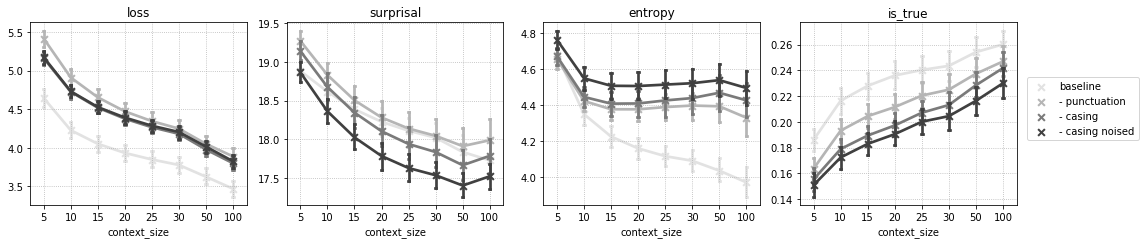

In [404]:
fig, ax = plt.subplots(ncols=4, figsize=(16,3.5))
for i, m in enumerate(metrics):
    sns.pointplot(data=aggs, 
                  x='context_size', 
                  y=m, 
                  hue='case_sensitive', 
                  ax=ax[i],
                  hue_order=types,
                  palette='Greys', 
                  markers='x', 
                  capsize=.05)
    ax[i].set_title(m)
    ax[i].set_ylabel('')
    if i!=3:
        ax[i].get_legend().remove()
    else:
        ax[i].legend(bbox_to_anchor=(1.05, .7), 
                     loc=2, 
                     borderaxespad=0.)
    ax[i].grid(linestyle='dotted')
plt.tight_layout()
plt.show()

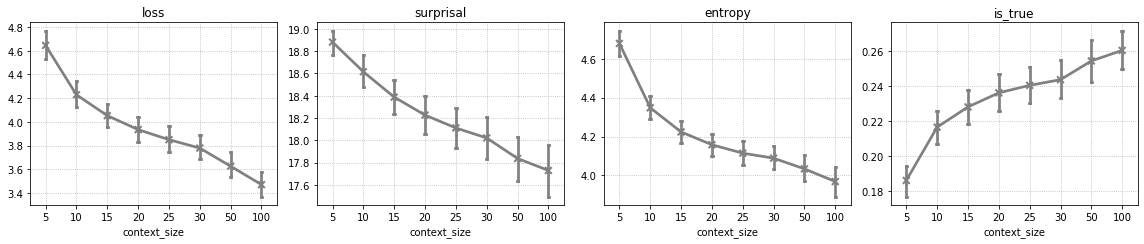

In [610]:
fig, ax = plt.subplots(ncols=4, figsize=(16,3.5))
for i, m in enumerate(metrics):
    sns.pointplot(data=aggs[aggs['case_sensitive']=='baseline'], 
                  x='context_size', 
                  y=m, 
                  ax=ax[i],
                  markers='x', 
                  color='grey',
                  capsize=.05)
    ax[i].set_title(m)
    ax[i].set_ylabel('')
    ax[i].grid(linestyle='dotted')
plt.tight_layout()
plt.show()

In [611]:
refs = aggs[aggs['case_sensitive']=='baseline']

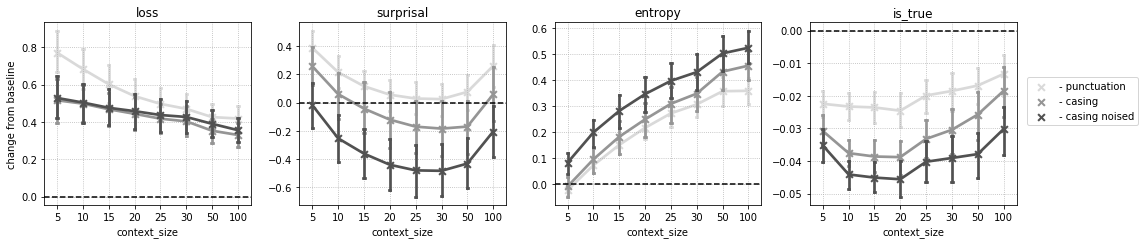

In [612]:
ds = []
for d in datasets:
    for t in types[1:]:
        a = aggs[(aggs['dataset']==d) & (aggs['case_sensitive']==t)].sort_values(by='context_size')
        r = refs[(refs['dataset']==d)].sort_values(by='context_size')
        for m in metrics:
            a[m] = a[m].values-r[m].values
        ds.append(a)
ds = pd.concat(ds)
fig, ax = plt.subplots(ncols=4, figsize=(16,3.5))
for i, m in enumerate(metrics):
    sns.pointplot(data=ds, 
                  x='context_size', 
                  y=m, 
                  hue='case_sensitive', 
                  ax=ax[i],
                  hue_order=types[1:],
                  palette='Greys', 
                  markers='x', 
                  capsize=.05)
    ax[i].set_title(m)
    ax[i].set_ylabel('')
    if i!=3:
        ax[i].get_legend().remove()
    else:
        ax[i].legend(bbox_to_anchor=(1.05, .7), 
                     loc=2, 
                     borderaxespad=0.)
    ax[i].axhline(0.0, color='black', linestyle='dashed')
    ax[i].grid(linestyle='dotted')
    if i==0:
        ax[i].set_ylabel('change from baseline')
plt.tight_layout()
plt.show()

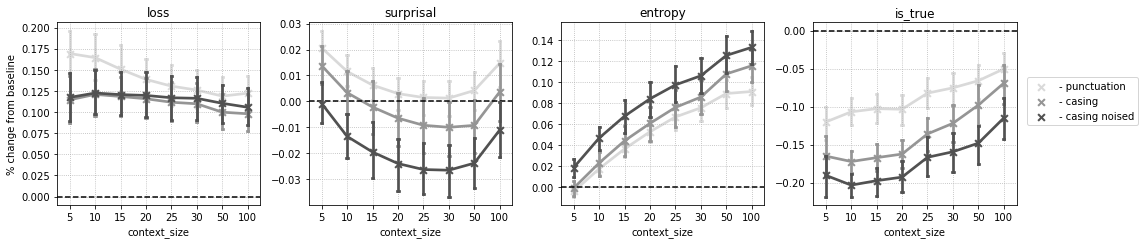

In [613]:
ds = []
for d in datasets:
    for t in types[1:]:
        a = aggs[(aggs['dataset']==d) & (aggs['case_sensitive']==t)].sort_values(by='context_size')
        r = refs[(refs['dataset']==d)].sort_values(by='context_size')
        for m in metrics:
            a[m] = (a[m].values-r[m].values) / r[m].values
        ds.append(a)
ds = pd.concat(ds)
fig, ax = plt.subplots(ncols=4, figsize=(16,3.5))
for i, m in enumerate(metrics):
    sns.pointplot(data=ds, 
                  x='context_size', 
                  y=m, 
                  hue='case_sensitive', 
                  ax=ax[i],
                  hue_order=types[1:],
                  palette='Greys', 
                  markers='x', 
                  capsize=.05)
    ax[i].set_title(m)
    ax[i].set_ylabel('')
    if i!=3:
        ax[i].get_legend().remove()
    else:
        ax[i].legend(bbox_to_anchor=(1.05, .7), 
                     loc=2, 
                     borderaxespad=0.)
    ax[i].axhline(0.0, color='black', linestyle='dashed')
    ax[i].grid(linestyle='dotted')
    if i==0:
        ax[i].set_ylabel('% change from baseline')
plt.tight_layout()
plt.show()

### Pairwise correlations

In [419]:
from itertools import combinations
pairs = list(combinations(types, 2))

In [420]:
outs = []
for d in datasets:
    for c in context_size:
        for p in pairs:
                ds = all_logs[all_logs['dataset']==d]
                ds = ds[ds['context_size']==c]
                p1 = ds[ds['case_sensitive']==p[0]]
                p2 = ds[ds['case_sensitive']==p[1]]
                for m in metrics:
                    cc = np.corrcoef(p1[m], p2[m])[0,1]
                    outs.append((m,d,c,p[0],p[1],cc))
outd = pd.DataFrame(outs, 
                    columns=['metric',
                             'dataset',
                             'context',
                             'type0',
                             'type1',
                             'corr'])

In [421]:
ags = outd.groupby(['metric', 'context', 
                    'type0', 'type1'])['corr'].mean().reset_index()
ags = ags[ags['type0']=='baseline'].drop('type0', axis=1)

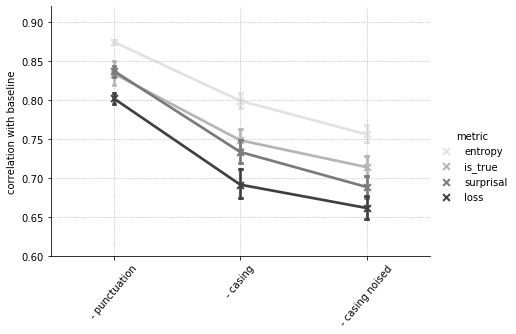

In [614]:
sns.catplot(data=ags, hue='metric', 
            x='type1', y='corr', 
            kind='point', 
            order=['- punctuation', '- casing', '- casing noised'], 
            palette='Greys',
            hue_order=['entropy', 'is_true', 'surprisal', 'loss'], 
            height=4, aspect=1.5, 
            markers='x',
            capsize=.02)
plt.ylim(.6,.92)
plt.xlabel('')
plt.ylabel('correlation with baseline')
plt.xticks(rotation=50)
plt.grid(linestyle='dotted')
plt.show()

In [615]:
all_logs['id'] = all_logs.groupby(['dataset', 
                                   'case_sensitive',
                                   'context_size']).cumcount()+1;

In [616]:
viz = all_logs.pivot(index=['dataset', 'model', 'context_size', 'id'], 
                     columns='case_sensitive', 
                     values=['top_predicted', 'context']).reset_index()
viz.columns = ['dataset', 'model', 'context_size', 'id', 
               '- casing', '- casing noised', '- punctuation', 'baseline',
               '- casing context', '- casing noised context', 
               '- punctuation context', 'baseline context']
viz = viz[['dataset', 'model', 'context_size', 'id', 
           'baseline', '- punctuation', '- casing', '- casing noised', 
           'baseline context', '- punctuation context', 
           '- casing context',  '- casing noised context']]

In [598]:
pd.options.display.max_colwidth = 300
viz[viz['context_size']==10][viz['baseline']!=viz['- punctuation']].sample(n=50).iloc[10:20,2:9]